In [101]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go
import time
from datetime import timedelta
import json
import os
import psutil
import gc

gc.collect()  
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [102]:
############ customization
length = 24
width = 24
n1 = 13
n2 = 13
judge = 0

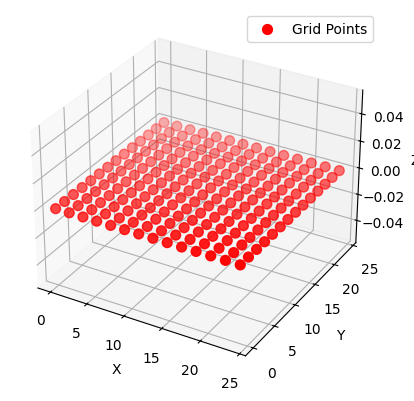

In [103]:
############### Problem context formulation

def generate_rectangular_grid_sg(length, width, n1, n2=2, judge=0, z=0, height=0):
    x_points = [i * (length / n1) for i in range(n1 + 1)]
    y_points = [j * (width / n2) for j in range(n2, -1, -1)]

    grid_points = []
    for x in x_points:
        for y in y_points:
            if y == width / 2:
                grid_points.append([x, y, height])
            else:
                grid_points.append([x, y, z])

    if judge == 1:
        corners = [
            [x_points[0], y_points[0], z],
            [x_points[0], y_points[-1], z],
            [x_points[-1], y_points[0], z],
            [x_points[-1], y_points[-1], z]
        ]
        grid_points = [point for point in grid_points if point not in corners]

    return grid_points

def plot_grid(grid_points, length, width):
    x = [point[0] for point in grid_points]
    y = [point[1] for point in grid_points]
    z = [point[2] for point in grid_points]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='r', marker='o', s=50, label='Grid Points')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

def generate_connectivity_matrix(new_coords):
    indexed_points = {tuple(point): idx + 1 for idx, point in enumerate(new_coords)}
    connectivity = []

    x_values = sorted(set(point[0] for point in new_coords))
    for x in x_values:
        points_on_line = [point for point in new_coords if point[0] == x]
        points_on_line.sort(key=lambda p: p[1], reverse=True) 

        for i in range(len(points_on_line) - 1):
            node1 = indexed_points[tuple(points_on_line[i])]
            node2 = indexed_points[tuple(points_on_line[i + 1])]
            connectivity.append([node1, node2])

    y_values = sorted(set(point[1] for point in new_coords))
    for y in y_values:
        points_on_line = [point for point in new_coords if point[1] == y]
        points_on_line.sort(key=lambda p: p[0])  

        for i in range(len(points_on_line) - 1):
            node1 = indexed_points[tuple(points_on_line[i])]
            node2 = indexed_points[tuple(points_on_line[i + 1])]
            connectivity.append([node1, node2])

    return connectivity

grid_points = generate_rectangular_grid_sg(length, width, n1, n2, judge)
connectivity = generate_connectivity_matrix(grid_points)
plot_grid(grid_points, length, width)


###########################################################################################################################################################
n_dof_per_node = 6  # Degrees of freedom per node
grid_points = torch.tensor(grid_points, device=device, dtype=torch.float32)
total_dof = n_dof_per_node * len(grid_points)

########## Surrounding fixed
x_max = grid_points[:, 0].max()
x_min = grid_points[:, 0].min()
y_max = grid_points[:, 1].max()
y_min = grid_points[:, 1].min()

Fixed_nodes = torch.where(
    (grid_points[:, 1] == y_max) |  # y = y_max
    (grid_points[:, 1] == y_min)    # y = y_min
)[0]

Fixed_nodes += 1
Free_nodes = []

n_elements = len(connectivity)
n_nodes = len(grid_points)

for i in range(1, n_nodes + 1):
    if i not in Fixed_nodes:
        Free_nodes.append(i)


####### BCs
fixed_dof = []
for node in Fixed_nodes:
    fixed_dof.extend([(node - 1) * 6 + i for i in range(6)])

##########################################################################################################################################################
##########################################################################################################################################################

In [104]:
############################################################# Force condition
def Force_mat(F_value, F_type, total_dof=total_dof, Free_nodes=Free_nodes, judge=0):
    
    F = torch.zeros(total_dof, dtype=torch.float32, device=device)
    
    if judge == 0:
        F_value = torch.tensor([F_value] * len(Free_nodes), device=device) * 1000 # The force value/direction
        F_type = [F_type] * len(Free_nodes)  # The force type
    else:
        F_value = torch.tensor(F_value) * 1000
        F_value = torch.tensor(F_type)
    
    for idx, i in enumerate(Free_nodes):
        F[6 * (i - 1) + F_type[idx]] = F_value[idx]  # unit: KN / KN*m
        
    return F, F_value

In [105]:

def Symmetry_shaper(grid_points, connectivity, free_nodes):
    
    connectivity = torch.tensor(connectivity, dtype=torch.long, device=device)
    free_nodes = torch.tensor(free_nodes, dtype=torch.long, device=device)
    
    result_indices_x = []  
    result_indices_y = []  
    prev_x_list = []  
    prev_y_list = []  
    
    for node in free_nodes:
        node_coord = grid_points[node - 1] 
        x = node_coord[0]

        if x in prev_x_list:
            x_index = prev_x_list.index(x)
        else:
            result_indices_x.append([])
            prev_x_list.append(x)
            x_index = len(prev_x_list) - 1
        
        mask = (connectivity == node).any(dim=1)
        candidate_indices = torch.where(mask)[0] # indexing connectivity
        
        for idx in candidate_indices:
            conn = connectivity[idx]
            coord1 = grid_points[conn[0] - 1]
            coord2 = grid_points[conn[1] - 1]

            if coord1[0] == coord2[0] and coord1[0] == x:
                result_indices_x[x_index].append(idx.item())  
    
    for node in free_nodes:
        node_coord = grid_points[node - 1]  
        y = node_coord[1]
        
        if y in prev_y_list:
            y_index = prev_y_list.index(y)
        else:
            result_indices_y.append([])
            prev_y_list.append(y)
            y_index = len(prev_y_list) - 1
        
        mask = (connectivity == node).any(dim=1)
        candidate_indices = torch.where(mask)[0]
           
        for idx in candidate_indices:
            conn = connectivity[idx]
            coord1 = grid_points[conn[0] - 1]
            coord2 = grid_points[conn[1] - 1]
            if coord1[1] == coord2[1] and coord1[1] == y:
                result_indices_y[y_index].append(idx.item()) 

    max_len_x = max(len(indices) for indices in result_indices_x) if result_indices_x else 0
    max_len_y = max(len(indices) for indices in result_indices_y) if result_indices_y else 0
    
    for indices in result_indices_x:
        indices += [-1] * (max_len_x - len(indices))
    for indices in result_indices_y:
        indices += [-1] * (max_len_y - len(indices))
    
    result_x = torch.tensor(result_indices_x, dtype=torch.long, device=device)
    result_y = torch.tensor(result_indices_y, dtype=torch.long, device=device)
    result_x = torch.unique(result_x, dim=1)
    result_y = torch.unique(result_y, dim=1)

    len_y = result_y.size(0)
    half_y = len_y // 2
    len_x = result_x.size(0)
    half_x = len_x // 2
    
    y_upper = result_y[:half_y]  
    y_lower = result_y[half_y:]
    y_lower = torch.flip(y_lower, dims=[0])
    x_upper = result_x[:half_x] 
    x_lower = result_x[half_x:]
    x_lower = torch.flip(x_lower, dims=[0])
    
    idx_Y = torch.cat((y_upper, y_lower), dim=1)
    idx_X = torch.cat((x_upper, x_lower), dim=1)

    return idx_X, idx_Y


In [106]:
def save_fdm(state_idx, grid_points, new_node_coords, 
            connectivity, Free_nodes, Fixed_nodes, force, SED,
            save_dir="results", max_states=6):
    """
    多状态组合图保存函数
    
    参数:
        state_idx: 状态序号 (0=初始, 1=第cut次, 2=第2*cut次...)
        max_states: 组合图中最多显示的状态数
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # 数据准备
    x_orig = grid_points[:, 0].cpu().detach().numpy()
    y_orig = grid_points[:, 1].cpu().detach().numpy()
    z_orig = grid_points[:, 2].cpu().detach().numpy()
    
    x_fdm = new_node_coords[:, 0].cpu().detach().numpy()
    y_fdm = new_node_coords[:, 1].cpu().detach().numpy()
    z_fdm = new_node_coords[:, 2].cpu().detach().numpy()
    
    # 计算当前高度
    current_height = max(z_fdm)
    
    # 初始化图形容器
    if not hasattr(save_fdm, 'fig'):
        save_fdm.fig = plt.figure(figsize=(24, 16))
        save_fdm.axes = [save_fdm.fig.add_subplot(2, 3, i+1, projection='3d') 
                       for i in range(max_states)]
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        save_fdm.saved_states = 0
        save_fdm.max_z = 0  # 用于统一z轴尺度
    
    # 检查是否已存满
    if save_fdm.saved_states >= max_states:
        filename = os.path.join(save_dir, f"FDM_States_{max_states}.png")
        save_fdm.fig.savefig(filename, dpi=200, bbox_inches='tight')
        plt.close(save_fdm.fig)
        delattr(save_fdm, 'fig')
        delattr(save_fdm, 'axes')
        delattr(save_fdm, 'saved_states')
        delattr(save_fdm, 'max_z')
        print(f"Saved full states to {filename}")
        return
    
    # 更新最大z值（用于统一坐标尺度）
    if current_height > save_fdm.max_z:
        save_fdm.max_z = current_height
    
    # 获取当前子图并清除旧内容
    ax = save_fdm.axes[save_fdm.saved_states]
    ax.clear()
    
    # ========== 可视化绘制 ==========
    # 1. 绘制原始网格（浅灰色虚线）
    for i, j in connectivity:
        ax.plot([x_orig[i-1], x_orig[j-1]],
                [y_orig[i-1], y_orig[j-1]],
                [z_orig[i-1], z_orig[j-1]], 
                ':', color='#CCCCCC', linewidth=0.8, alpha=0.7)
    
    # 2. 绘制当前状态网格
    color = '#1f77b4' if state_idx == 0 else '#ff7f0e'  # 初始蓝色，迭代橙色
    for i, j in connectivity:
        ax.plot([x_fdm[i-1], x_fdm[j-1]],
                [y_fdm[i-1], y_fdm[j-1]],
                [z_fdm[i-1], z_fdm[j-1]], 
                '-', color=color, linewidth=1.8, alpha=0.9)
    
    # 3. 标记固定节点（黑色实心圆）
    for node in Fixed_nodes:
        ax.scatter(x_fdm[node-1], y_fdm[node-1], z_fdm[node-1],
                  c='black', s=50, marker='o', alpha=0.8)
    
    # 4. 添加高度标注（替换原来的力值标注）
    ax.text(x=0.05, y=0.90, z=save_fdm.max_z*1.05,
           s=f"Height: {current_height:.2f}m\nSE: {SED:.8f} ", 
           transform=ax.transAxes, 
           fontsize=10,
           bbox=dict(facecolor='white', alpha=0.7))
    
    # ========== 子图装饰 ==========
    ax.set_xlabel('X (m)', fontsize=9)
    ax.set_ylabel('Y (m)', fontsize=9)
    ax.set_zlabel('Z (m)', fontsize=9)
    ax.set_title(f"State {state_idx}" if state_idx > 0 else "Initial State", 
                fontsize=11, pad=12)
    ax.set_zlim(0, save_fdm.max_z * 1.1)  # 统一z轴尺度
    ax.view_init(elev=35, azim=45)
    ax.grid(True, linestyle=':', alpha=0.5)
    
    # 更新状态计数器
    save_fdm.saved_states += 1
    
    # 如果是最后一个状态，立即保存
    if save_fdm.saved_states == max_states:
        filename = os.path.join(save_dir, f"FDM_States_{max_states}.png")
        save_fdm.fig.savefig(filename, dpi=200, bbox_inches='tight')
        plt.close(save_fdm.fig)
        delattr(save_fdm, 'fig')
        delattr(save_fdm, 'axes')
        delattr(save_fdm, 'saved_states')
        delattr(save_fdm, 'max_z')
        print(f"Saved full states to {filename}")


def finalize_fdm(save_dir="results", completed=False):
    """
    最终化处理函数
    
    参数:
        save_dir: 保存目录
        completed: 是否完成所有迭代 (True=已完成全部迭代，False=提前终止)
    """
    if not hasattr(save_fdm, 'fig') or save_fdm.saved_states == 0:
        return
    
    # 如果已完成所有迭代，保存当前进度（不强制填满）
    if completed:
        filename = os.path.join(save_dir, 
                              f"FDM_States_completed_{save_fdm.saved_states}.png")
    # 如果是提前终止，保存上一次有效迭代
    else:
        # 回退一个状态，因为最后一次迭代可能不完整
        save_fdm.saved_states = max(0, save_fdm.saved_states - 1)
        filename = os.path.join(save_dir,
                              f"FDM_States_partial_{save_fdm.saved_states+1}.png")
    
    # 保存图像
    save_fdm.fig.savefig(filename, dpi=200, bbox_inches='tight')
    plt.close(save_fdm.fig)
    
    # 打印保存信息
    if completed:
        print(f"Saved completed states ({save_fdm.saved_states}/{len(save_fdm.axes)}) to {filename}")
    else:
        print(f"Saved last valid state ({save_fdm.saved_states+1}) to {filename}")
    
    # 清理属性
    for attr in ['fig', 'axes', 'saved_states', 'max_z']:
        if hasattr(save_fdm, attr):
            delattr(save_fdm, attr)







In [107]:
####### FDM part 
C = torch.zeros(n_elements, n_nodes, dtype=torch.float32, device=device)
for n, (i, j) in enumerate(connectivity):
    C[n, i - 1] = 1
    C[n, j - 1] = -1
    
px= torch.zeros(len(Free_nodes), 1, dtype=torch.float32, device=device)
py = torch.zeros(len(Free_nodes), 1, dtype=torch.float32, device=device)
pz = torch.zeros(len(Free_nodes), 1, dtype=torch.float32, device=device)


fixed_idces = torch.tensor([node - 1 for node in Fixed_nodes], device=device)
free_node_indices = torch.tensor([node - 1 for node in Free_nodes], device=device)

CF = C[:, fixed_idces]
CN = C[:, free_node_indices]

def FDM(Q, F_value, CN=CN, CF=CF, px=px, py=py, pz=pz, 
        fixed_idces=fixed_idces, free_node_indices=free_node_indices,
        node_coords=grid_points):
    
    pz[:, 0] = F_value
        
    Dn = torch.matmul(torch.transpose(CN, 0, 1), torch.matmul(Q, CN))
    DF = torch.matmul(torch.transpose(CN, 0, 1), torch.matmul(Q, CF))
    
    
    xF = node_coords[fixed_idces, 0].unsqueeze(1)
    yF = node_coords[fixed_idces, 1].unsqueeze(1)
    zF = node_coords[fixed_idces, 2].unsqueeze(1)
    
    xN = torch.matmul(torch.inverse(Dn), (px - torch.matmul(DF, xF)))
    yN = torch.matmul(torch.inverse(Dn), (py - torch.matmul(DF, yF)))
    zN = torch.matmul(torch.inverse(Dn), (pz - torch.matmul(DF, zF)))
        
    
    new_node_coords = node_coords.clone()
    new_node_coords[free_node_indices, 0] = xN.squeeze()
    new_node_coords[free_node_indices, 1] = yN.squeeze()
    new_node_coords[free_node_indices, 2] = zN.squeeze()
    
    return new_node_coords

In [108]:
###### FE part
D_radius = 0.75
D_young_modulus = 10e9 
D_shear_modulus = 0.7e9 
D_poisson_ratio = 0.3
cross_section_angle_a = 0  
cross_section_angle_b = 0  
a_small_number = 1e-10

def rotation(v, k, theta):
    """Rotation of vector v around axis k by angle theta."""
    k = k / torch.norm(k)  # Normalize k
    cross_product = torch.cross(k, v)
    dot_product = torch.dot(k, v)

    # Ensure theta is a tensor
    theta = torch.tensor(theta, dtype=torch.float32, device=device) if not isinstance(theta, torch.Tensor) else theta

    v_rotated = v * torch.cos(theta) + cross_product * torch.sin(theta) + k * dot_product * (1 - torch.cos(theta))
    return v_rotated

class Beam:
    def __init__(self, node_coordinates, R=D_radius, young_modulus=D_young_modulus,
                 shear_modulus=D_shear_modulus, poisson_ratio=D_poisson_ratio, Beta_a=cross_section_angle_a,
                 Beta_b=cross_section_angle_b):
        self.node_coordinates = node_coordinates  # (2, 3) tensor for node coordinates

        # Material and geometry
        self.radius = R
        self.young_modulus = young_modulus
        self.shear_modulus = shear_modulus
        self.poisson_ratio = poisson_ratio

        # Cross-sectional properties
        self.length = torch.norm(self.node_coordinates[1] - self.node_coordinates[0])  # Length of the beam
        self.Iy = (torch.pi * self.radius ** 4) / 4 
        self.Iz = self.Iy
        self.A = torch.pi * self.radius ** 2
        self.J = (torch.pi * self.radius ** 4) / 2

        # Stiffness components
        self.S_u = self.young_modulus * self.A / self.length
        self.S_v1a = 12 * self.young_modulus * self.Iy / (self.length ** 3)
        self.S_v1b = 6 * self.young_modulus * self.Iy / (self.length ** 2)
        self.S_v2a = 12 * self.young_modulus * self.Iz / (self.length ** 3)
        self.S_v2b = 6 * self.young_modulus * self.Iz / (self.length ** 2)
        self.S_theta1a = 6 * self.young_modulus * self.Iy / (self.length ** 2)
        self.S_theta1b = 4 * self.young_modulus * self.Iy / self.length
        self.S_theta1c = 2 * self.young_modulus * self.Iy / self.length
        self.S_theta2a = 6 * self.young_modulus * self.Iz / (self.length ** 2)
        self.S_theta2b = 4 * self.young_modulus * self.Iz / self.length
        self.S_theta2c = 2 * self.young_modulus * self.Iz / self.length
        self.S_Tr = self.shear_modulus * self.J / self.length

        # Section rotations at the two ends
        self.Beta_a = Beta_a
        self.Beta_b = Beta_b

    def get_element_stiffness_matrix(self):
        """Element stiffness matrix."""
        K_element = torch.tensor([
            [self.S_u, 0, 0, 0, 0, 0, -self.S_u, 0, 0, 0, 0, 0],
            [0, self.S_v1a, 0, 0, 0, self.S_theta1a, 0, -self.S_v1a, 0, 0, 0, self.S_theta1a],
            [0, 0, self.S_v2a, 0, -self.S_theta2a, 0, 0, 0, -self.S_v2a, 0, -self.S_theta2a, 0],
            [0, 0, 0, self.S_Tr, 0, 0, 0, 0, 0, -self.S_Tr, 0, 0],
            [0, 0, -self.S_v2b, 0, self.S_theta2b, 0, 0, 0, self.S_v2b, 0, self.S_theta2c, 0],
            [0, self.S_v1b, 0, 0, 0, self.S_theta1b, 0, -self.S_v1b, 0, 0, 0, self.S_theta1c],
            [-self.S_u, 0, 0, 0, 0, 0, self.S_u, 0, 0, 0, 0, 0],
            [0, -self.S_v1a, 0, 0, 0, -self.S_theta1a, 0, self.S_v1a, 0, 0, 0, -self.S_theta1a],
            [0, 0, -self.S_v2a, 0, self.S_theta2a, 0, 0, 0, self.S_v2a, 0, self.S_theta2a, 0],
            [0, 0, 0, -self.S_Tr, 0, 0, 0, 0, 0, self.S_Tr, 0, 0],
            [0, 0, -self.S_v2b, 0, self.S_theta2c, 0, 0, 0, self.S_v2b, 0, self.S_theta2b, 0],
            [0, self.S_v1b, 0, 0, 0, self.S_theta1c, 0, -self.S_v1b, 0, 0, 0, self.S_theta1b],
        ], dtype=torch.float32, device=device)

        return K_element

    def System_Transform(self):
        """Coordinate transformation matrix."""
        vector_x = self.node_coordinates[1, 0] - self.node_coordinates[0, 0]
        vector_y = self.node_coordinates[1, 1] - self.node_coordinates[0, 1]
        vector_z = self.node_coordinates[1, 2] - self.node_coordinates[0, 2]
        length = torch.norm(self.node_coordinates[1] - self.node_coordinates[0])
        
        z_value = torch.clamp(vector_z / length, min=-1 + 1e-6, max=1 - 1e-6)
        ceta = torch.acos(z_value)
        value = vector_x / torch.sqrt(vector_y ** 2 + vector_x ** 2 + a_small_number)
        value = torch.clamp(value, min=-1 + 1e-6, max=1 - 1e-6)
        alpha = torch.acos(value)

        Projection_Z_x = - vector_z / length * torch.sin(alpha)
        Projection_Z_y = - vector_z / length * torch.cos(alpha)
        Projection_Z_z = torch.cos(torch.pi / 2 - ceta)

        V_projection = torch.stack([Projection_Z_x, Projection_Z_y, Projection_Z_z])
        X_axis = torch.stack([vector_x / length, vector_y / length, vector_z / length])
        Z_axis_a = rotation(V_projection, X_axis, self.Beta_a)
        Y_axis_a = rotation(Z_axis_a, X_axis, -torch.pi / 2)
        Z_axis_a = Z_axis_a / torch.norm(Z_axis_a)
        Y_axis_a = Y_axis_a / torch.norm(Y_axis_a)

        lambda_matrix = torch.stack([X_axis, Y_axis_a, Z_axis_a], dim=0)
        matrix_T = torch.zeros((12, 12), dtype=torch.float32, device=device)
        for i in range(0, 12, 3):
            matrix_T[i:i + 3, i:i + 3] = lambda_matrix
        return matrix_T

    def nodal_transform(self):
        """Coordinate transformation matrix."""
        vector_x = self.node_coordinates[1, 0] - self.node_coordinates[0, 0]
        vector_y = self.node_coordinates[1, 1] - self.node_coordinates[0, 1]
        vector_z = self.node_coordinates[1, 2] - self.node_coordinates[0, 2]
        length = torch.norm(self.node_coordinates[1] - self.node_coordinates[0])
        
        z_value = torch.clamp(vector_z / length, min=-1 + 1e-6, max=1 - 1e-6)
        ceta = torch.acos(z_value)
        value = vector_x / torch.sqrt(vector_y ** 2 + vector_x ** 2 + a_small_number)
        value = torch.clamp(value, min=-1 + 1e-6, max=1 - 1e-6)
        alpha = torch.acos(value)

        Projection_Z_x = - vector_z / length * torch.sin(alpha)
        Projection_Z_y = - vector_z / length * torch.cos(alpha)
        Projection_Z_z = torch.cos(torch.pi / 2 - ceta)

        V_projection = torch.stack([Projection_Z_x, Projection_Z_y, Projection_Z_z])
        X_axis = torch.stack([vector_x / length, vector_y / length, vector_z / length])
        Z_axis_a = rotation(V_projection, X_axis, self.Beta_a)
        Y_axis_a = rotation(Z_axis_a, X_axis, -torch.pi / 2)
        Z_axis_a = Z_axis_a / torch.norm(Z_axis_a)
        Y_axis_a = Y_axis_a / torch.norm(Y_axis_a)

        lambda_matrix = torch.stack([X_axis, Y_axis_a, Z_axis_a], dim=0)
        return lambda_matrix


def assemble_stiffness_matrix(beams, n_nodes, n_dof_per_node, connectivity):
    """Global stiffness matrix assembly."""
    total_dof = n_nodes * n_dof_per_node  # Total degrees of freedom
    K_global = torch.zeros((total_dof, total_dof), dtype=torch.float32, device=device)
    
    for idx, (i, j) in enumerate(connectivity):
        Matrix_T = beams[idx].System_Transform()  # Get transformation matrix
        K_element = torch.matmul(torch.transpose(Matrix_T, 0, 1),
                                 torch.matmul(beams[idx].get_element_stiffness_matrix(), Matrix_T))

        start_idx = (i - 1) * n_dof_per_node
        end_idx = (j - 1) * n_dof_per_node
        K_global[start_idx:start_idx + 6, start_idx:start_idx + 6] += K_element[0:6, 0:6]
        K_global[end_idx:end_idx + 6, end_idx:end_idx + 6] += K_element[6:12, 6:12]
        K_global[start_idx:start_idx + 6, end_idx:end_idx + 6] += K_element[0:6, 6:12]
        K_global[end_idx:end_idx + 6, start_idx:start_idx + 6] += K_element[6:12, 0:6]

    return K_global

def robust_solve(K_global, F, fixed_dof, max_attempts=3):
    
    attempts = 0
    while attempts < max_attempts:
        reg = 1e-6 * torch.eye(K_global.shape[0], device=K_global.device)
        reg[fixed_dof, fixed_dof] = 0  
        K_reg = K_global + reg
        
        try:
            displacements = torch.linalg.solve(
                K_reg.to(torch.float64), 
                F.to(torch.float64)
            )
            return displacements.to(K_global.dtype)
            
        except RuntimeError:
            diag = torch.diag(K_global)
            extreme_mask = (diag > 1e12) & (~torch.isin(torch.arange(len(diag)), torch.tensor(fixed_dof)))  
            K_reg[extreme_mask] = 0
            K_reg[:, extreme_mask] = 0
            K_reg[extreme_mask, extreme_mask] = 1e12  
            
            K_reg[fixed_dof, :] = 0
            K_reg[:, fixed_dof] = 0
            K_reg[fixed_dof, fixed_dof] = 1e10  
            
            try:
                displacements, info = torch.linalg.cg(
                    K_reg.to(torch.float64),
                    F.to(torch.float64),
                    maxiter=5000,
                    atol=1e-6
                )
                if info > 0:
                    raise RuntimeError("CG nah nah")
                return displacements.to(K_global.dtype)
                
            except:
                K_pinv = torch.linalg.pinv(K_reg)
                K_pinv[fixed_dof, :] = 0  
                displacements = K_pinv @ F
                print("警告：使用伪逆求解，精度可能降低")
                return displacements
                
        attempts += 1
    
    raise RuntimeError("无法求解线性系统")


def Strain_E(node_coords, connectivity, fixed_dof, F):
    # Element Assembly
    Beam_lens = []
    beams = []
    for connection in connectivity:
        node_1_coords = node_coords[connection[0] - 1]
        node_2_coords = node_coords[connection[1] - 1]
        beam = Beam(node_coordinates=torch.stack([node_1_coords, node_2_coords]),
                    R=D_radius, young_modulus=D_young_modulus,
                    shear_modulus=D_shear_modulus, poisson_ratio=D_poisson_ratio, Beta_a=cross_section_angle_a,
                    Beta_b=cross_section_angle_b)
        beams.append(beam)
        Beam_lens.append(beam.length)
    
    # Stiffness renewal
    K_global = assemble_stiffness_matrix(beams, n_nodes=len(node_coords), n_dof_per_node=6, connectivity=connectivity)
    K_global[fixed_dof, :] = 0
    K_global[:, fixed_dof] = 0
    K_global[fixed_dof, fixed_dof] = 1e10

    displacements = robust_solve(K_global, F, fixed_dof)

    # Compute strain energy
    strain_energy_list = []
    force_list = []
    ASE_list = []
    V_list = []
    Local_d = torch.zeros(len(connectivity), 12, dtype=torch.float32, device=device)
    for n, (i, j) in enumerate(connectivity):
        matrix_T = beams[n].System_Transform()
        Tep_displacements = torch.cat(
            [displacements[6 * (i - 1):6 * (i - 1) + 6], displacements[6 * (j - 1):6 * (j - 1) + 6]], dim=0)
        Local_d_n = torch.matmul(Tep_displacements, matrix_T.T)
        Local_d[n, :] = Local_d_n.clone()
        K_l = beams[n].get_element_stiffness_matrix()
        strain_energy_list.append(0.5 * torch.matmul(Local_d_n, torch.matmul(K_l, Local_d_n.reshape(-1, 1))))
        force_list.append(torch.matmul(K_l, Local_d_n.reshape(-1, 1)))
        ASE_list.append(0.5 * (Local_d_n[0]-Local_d_n[6]) * beams[n].S_u * (Local_d_n[0]-Local_d_n[6]))  
        V_list.append(beams[n].A * beams[n].length)
    
     
    
    Strain_energy = torch.stack(strain_energy_list)
    forces = torch.stack(force_list)
    ASE = torch.stack(ASE_list)
    lens = torch.stack(Beam_lens)
    # epsilon = Local_d[:, 0] / lens
    # Axial_d = Local_d[:, 0]
    V = torch.stack(V_list)
    SED = Strain_energy / lens 
    R = torch.var(SED)
    
    return Strain_energy, forces, displacements, ASE, lens, R, V

In [109]:
def finite_difference_gradient(q, idx_X, idx_Y, r, F_value, connectivity, fixed_dof, F_fe, h=1e-6):
    ini = time.time()
    n_params = q.shape[0]
    grad = torch.zeros_like(q)
    
    for i in range(n_params):
        # 创建扰动变量（避免原地修改）
        q_plus = q.detach().clone()
        q_minus = q.detach().clone()
        
        # 施加扰动（注意：必须创建新Tensor）
        q_plus[i] += h
        q_minus[i] -= h
        
        # 正向扰动计算
        q_vec_plus = torch.zeros(n_elements, device=q.device)
        for j in range(len(idx_X)):
            q_vec_plus[idx_X[j,:]] = q_plus[j]
        for j in range(len(idx_Y)):
            q_vec_plus[idx_Y[j,:]] = q_plus[j+len(idx_X)]
        SE_plus = Strain_E(FDM(torch.diag(q_vec_plus/r), F_value), connectivity, fixed_dof, F_fe)[0].sum()
        
        # 负向扰动计算
        q_vec_minus = torch.zeros_like(q_vec_plus)
        for j in range(len(idx_X)):
            q_vec_minus[idx_X[j,:]] = q_minus[j]
        for j in range(len(idx_Y)):
            q_vec_minus[idx_Y[j,:]] = q_minus[j+len(idx_X)]
        SE_minus = Strain_E(FDM(torch.diag(q_vec_minus/r), F_value), connectivity, fixed_dof, F_fe)[0].sum()
        
        # 中心差分
        grad[i] = (SE_plus - SE_minus) / (2 * h)
        
    end = time.time() - ini
    print(end)
    return grad

In [110]:
def optimizer(q, gradients, step):
    
    q.data -= gradients / torch.norm(gradients ) * step

    return q
    
def check_available_memory():
    """返回当前可用CPU内存（MB）"""
    return psutil.virtual_memory().available / (1024 ** 2)

In [111]:
############### Formulating :::::
####### Gradient descent
step = 0.001
epochs = 400
# Initilizing
patience = 20
count = 0
idx_X, idx_Y = Symmetry_shaper(grid_points, connectivity, Free_nodes)
####### Force Condition

_, F_value = Force_mat(- 1, 2)
F_fe_g, _ = Force_mat(-1, 2)

F_fe = F_fe_g

r = 1 / torch.max(F_value)

print('r', r)

r tensor(-0.0010)


In [112]:
############## Optimization loop

#### Initializing Data storage
os.makedirs("data_records", exist_ok=True)
optimization_data = {
    "metadata": {
        "project": "Structural Optimization",
        "Context": "FDM + FE",
        "device": str(device),
        "parameters": {
            "length": length,
            "width": width,
            "grid_size": f"{n1}x{n2}",
            "epochs": epochs,
            "step_size": step
        }
    },
    "iterations": []
}

####### Loop start
n_elem = len(connectivity)
q = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], requires_grad=True, device=device)
start_time = time.time()
cut = epochs / 5
ES_his = []
LP_his = []
LS_his = []
R_his = []
Ratio = []

# Loop start
for iteration in range(epochs + 1):
    print('ite', iteration)
    
    iter_start = time.time() 
    
    avail_mem = check_available_memory()
    print(f"Iter {iteration} - Available Memory: {avail_mem:.2f} MB")
    if avail_mem < 1000: 
        print(f"⚠️  Low memory warning: {avail_mem:.2f} MB left!")
    
    # Forwards
    q_vec = torch.zeros(n_elements, requires_grad=True, device=device).clone()
    for i in range(len(idx_X)):
        q_vec[idx_X[i,:]] = q[i] 
    for j in range(len(idx_Y)):
        q_vec[idx_Y[j,:]] = q[j+len(idx_X)]  
    q_vec = q_vec * 1 / r
    Q = torch.diag(q_vec) 
    new_node_coords = FDM(Q, F_value)
    height = max(new_node_coords[:,2])
    
    
    ####### FDM time
    FDM_time = (time.time() - iter_start) / 60
        
    N_coords = new_node_coords.clone()
    FE_str = time.time()
    Strain_energy, forces, displacements, ASE, Beam_lens, R, V = Strain_E(N_coords, connectivity, fixed_dof, F_fe)
    
    ######## FE time
    FE_time = (time.time() - FE_str) / 60       
    force = abs(forces[:, 0, 0])
    load_path = torch.dot(force , Beam_lens)


    Total_ES = torch.sum(Strain_energy) 
    Axial_rate = torch.sum(ASE) / Total_ES

    Volume = torch.sum(V)
    Loss = torch.dot(abs(q_vec * Beam_lens), Beam_lens)

    
    # Loss_his.append(loss.item())
    R_his.append(R.clone().detach().item())
    LP_his.append(load_path.item()) 
    ES_his.append(Total_ES.item())
    Ratio.append(torch.sum(ASE) / Total_ES) 
    LS_his.append(Loss.clone().detach().item())
    
    print('Ratio', torch.sum(ASE) / Total_ES)
    print("Estrain:", Total_ES)
    print('load_path', load_path)
    print("R:", R)
    print('ite height:', height)

    ############################ Deformation
    N_coords = N_coords.reshape(-1)
    New_Coordinates = torch.zeros(n_nodes * 3, dtype=torch.float32, device=device)
    for n in range(n_nodes):
        New_Coordinates[3*n : 3*n+3] = N_coords[3*n : 3*n+3] + displacements[6*n : 6*n+3]
    New_Coordinates = New_Coordinates.view(n_nodes, 3).clone()
        
    # Backwards
    
    Back_str = time.time()
    if q.grad is not None:
        q.grad.detach_()
        q.grad.zero_()
       
    Total_ES.backward(retain_graph=True)
    Back_time = (time.time() - Back_str) / 60
    
    # Grad
    gradients = q.grad
    frob_norm = torch.norm(gradients)
    q = optimizer(q, gradients, step)
    
    Wins_q = q.cpu().clone().detach()
    print('Wins_q', Wins_q)    
    print('Wins_grad', gradients) 
    
    with torch.no_grad():
        q[:5].clamp_(min=0.8, max=1.0)
        q[5:].clamp_(min=0.0, max=2.0)

    ####### Data storage:
    iteration_record = {
    "iteration": iteration,
    "variables": q.detach().cpu().numpy().tolist(),
    "strain_energy": Total_ES.item(),
    "Load_path": load_path.item(),
    "Axial SE ratio": Axial_rate.item(),
    "Volume": Volume.item(),
    "R": R.item(),
    "gradient_norm": torch.norm(gradients).item() if q.grad is not None else 0.0,
               "timing": {
            "FDM_time": FDM_time,
            "FE_time": FE_time,
            "Back_propagation time": Back_time,
        },
    }  
    optimization_data["iterations"].append(iteration_record)

    if iteration % cut == 0 or iteration == 0:
        state_idx = iteration // cut  
        save_fdm(state_idx, grid_points, new_node_coords, 
                connectivity, Free_nodes, Fixed_nodes, 
                force, Total_ES.detach().cpu().item())
    
    # print iteration
    if iteration % 5 == 0:
        print(f"Iteration {iteration}: Normalized Gradient = {frob_norm}, Adaptive learning rate = {step}")

    if iteration % 10 == 0:
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
            
    ######## Early stopping
    if iteration > 0:  
        Pre_Total_ES = ES_his[iteration - 1]  
        change = abs(Total_ES - Pre_Total_ES) / Pre_Total_ES 
        if change < 1/10000:
            count += 1
        else:
            count = 0 
        if count >= patience:
            print(f"Early stopping at iteration {iteration}: Total_ES change < 1%% for {patience} consecutive iterations.")
            break 
            

finalize_fdm()
total_time = (time.time() - iter_start) / 60
optimization_data["metadata"].update({
    "Ite_time": total_time,
})

with open(os.path.join("data_records", "FULL_data.json"), 'w') as f:
    json.dump(optimization_data, f, indent=2)
    
print("Optimization completed.")
print(q)
print("Estrain:", Total_ES)

ite 0
Iter 0 - Available Memory: 2394.23 MB
Ratio tensor(0.9979, grad_fn=<DivBackward0>)
Estrain: tensor(0.4431, grad_fn=<SumBackward0>)
load_path tensor(3161152.2500, grad_fn=<DotBackward0>)
R: tensor(8.9177e-07, grad_fn=<VarBackward0>)
ite height: tensor(21.0000, grad_fn=<UnbindBackward0>)
Wins_q tensor([ 9.9963e-01,  9.9962e-01,  9.9962e-01,  9.9962e-01,  9.9962e-01,
         9.9962e-01,  9.9962e-01, -2.5936e-06, -3.2533e-06, -3.5697e-06,
        -4.0625e-06, -4.9898e-06, -5.3282e-06])
Wins_grad tensor([0.0189, 0.0192, 0.0193, 0.0194, 0.0194, 0.0194, 0.0194, 0.0001, 0.0002,
        0.0002, 0.0002, 0.0003, 0.0003])
Iteration 0: Normalized Gradient = 0.05105757340788841, Adaptive learning rate = 0.001
ite 1
Iter 1 - Available Memory: 8636.97 MB
Ratio tensor(0.9979, grad_fn=<DivBackward0>)
Estrain: tensor(0.4432, grad_fn=<SumBackward0>)
load_path tensor(3161894.2500, grad_fn=<DotBackward0>)
R: tensor(8.9221e-07, grad_fn=<VarBackward0>)
ite height: tensor(21.0080, grad_fn=<UnbindBackwar

In [113]:
############## Optimization loop

####### Loop start
fdES_his = []
fd_epochs = 500
fd_step =  0.001
q = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# Loop start
for iteration in range(fd_epochs + 1):
    print('ite', iteration)
    
    q_vec = torch.zeros(n_elements, requires_grad=True, device=device).clone()
    for i in range(len(idx_X)):
        q_vec[idx_X[i,:]] = q[i] 
    for j in range(len(idx_Y)):
        q_vec[idx_Y[j,:]] = q[j+len(idx_X)]  
    q_vec = q_vec * 1 / r
    Q = torch.diag(q_vec) 
    new_node_coords = FDM(Q, F_value)
    height = max(new_node_coords[:,2])
    
    N_coords = new_node_coords.clone()
    FE_str = time.time()
    Strain_energy, forces, displacements, ASE, Beam_lens, R, V = Strain_E(N_coords, connectivity, fixed_dof, F_fe)
    
    ######## FE time   
    FD_ES = torch.sum(Strain_energy)
    fdES_his.append(FD_ES.item())

    # Grad
    gradients = finite_difference_gradient(
    q=q,
    idx_X=idx_X,
    idx_Y=idx_Y,
    r=r,
    F_value=F_value,
    connectivity=connectivity,
    fixed_dof=fixed_dof,
    F_fe=F_fe,
    h=1e-5
)
    

    with torch.no_grad():
        q = optimizer(q, gradients, fd_step)
        # 参数约束
        q[:5].clamp_(min=0.8, max=1.0)
        q[5:].clamp_(min=0.0, max=2.0)
        
    frob_norm = torch.norm(gradients)
    Wins_q = q
    print('Wins_q', Wins_q)    
    print('Wins_grad', gradients)
    print('Strain_energy',FD_ES)
    
    ######## Early stopping
    if iteration > 0:  
        Pre_FD_ES = fdES_his[iteration - 1]  
        change = abs(FD_ES - Pre_FD_ES) / Pre_FD_ES
        
        if change < 1/100000:
            count += 1
        else:
            count = 0 
        if count >= patience:
            print(f"Early stopping at iteration {iteration}: Total_ES change < 1%% for {patience} consecutive iterations.")
            break 

    
print("Optimization completed.")
print(q)
print("Estrain:", FD_ES)

ite 0
18.25650930404663
Wins_q tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0002e+00,
        1.0001e+00, 0.0000e+00, 2.0343e-04, 0.0000e+00, 0.0000e+00, 1.2593e-04,
        2.1312e-04])
Wins_grad tensor([-0.0477, -0.0432, -0.0551, -0.0373, -0.0373, -0.0253, -0.0119,  0.0596,
        -0.0313,  0.0745,  0.0373, -0.0194, -0.0328])
Strain_energy tensor(0.4431, grad_fn=<SumBackward0>)
ite 1
17.94102716445923
Wins_q tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0005e+00,
        1.0004e+00, 9.2854e-05, 1.9183e-04, 1.0446e-04, 1.1607e-05, 2.6522e-04,
        4.5686e-04])
Wins_grad tensor([-0.0447, -0.0477, -0.0283, -0.0715, -0.0283, -0.0432, -0.0447, -0.0119,
         0.0015, -0.0134, -0.0015, -0.0179, -0.0313])
Strain_energy tensor(0.4431, grad_fn=<SumBackward0>)
ite 2
62.07524800300598
tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0006e+00,
        1.0006e+00, 2.0913e-04, 4.2438e-04, 1.4599e-04, 2.6077e-04, 8.0507e-04

KeyboardInterrupt: 

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# 第一条曲线（自动微分 - ES_his）
color1 = 'tab:blue'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Strain Energy', color='black')
line1 = ax1.plot(ES_his, 
                label='AutoDiff (ES_his)', 
                color=color1, 
                linewidth=2,
                linestyle='-')

# 第二条曲线（有限差分 - fdES_his）
color2 = 'tab:red'
line2 = ax1.plot(fdES_his, 
                label='FiniteDiff (fdES_his)', 
                color=color2, 
                linewidth=2,
                linestyle='--')

# 标记点设置（同时标记两条曲线）
marker_points = [0, *range(50, max(len(ES_his), len(fdES_his)), 50), max(len(ES_his), len(fdES_his))-1]

for point in marker_points:
    if point < len(ES_his):
        ax1.scatter(point, ES_his[point], color=color1, zorder=5, s=60)
        ax1.text(point, ES_his[point], 
                f'Auto: {ES_his[point]:.2e}',
                ha='right' if point == len(ES_his)-1 else 'left',
                va='bottom',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7))
    
    if point < len(fdES_his):
        ax1.scatter(point, fdES_his[point], color=color2, zorder=5, s=60, marker='s')
        ax1.text(point, fdES_his[point], 
                f'FD: {fdES_his[point]:.2e}',
                ha='right' if point == len(fdES_his)-1 else 'left',
                va='top',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7))

# 图例和样式
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)
plt.title('Strain Energy Comparison: AutoDiff vs FiniteDiff')

# 自动调整y轴范围
combined = ES_his + fdES_his
ax1.set_ylim(min(combined)*0.95, max(combined)*1.05)

plt.tight_layout()
plt.savefig('ES_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'black'
ax1.set_ylabel('Strain energy', color=color)
ax1.plot(range(len(ES_his)), ES_his, label='Total_Es', color=color, linewidth=2, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

# Mark specific points
marker_points = [
    0,  # First point
    *range(50, len(ES_his), 50),  # Every 200th point
    len(ES_his)-1  # Last point
]

for point in marker_points:
    ax1.scatter(point, ES_his[point], color='blue', zorder=5)
    ax1.text(point, ES_his[point], 
             f'({ES_his[point]:.4f})',
             ha='right' if point == len(ES_his)-1 else 'left',
             va='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax1.legend(loc='upper right')
plt.title('Total_Strain energy vs. Iterations')
plt.tight_layout()
plt.savefig('Es_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
Ratio = torch.tensor(Ratio)


color = 'red'
ax1.set_ylabel('Axial_se_Ratio', color=color)
ax1.plot(range(len(Ratio)), Ratio.cpu().numpy(), label='LP', color=color, linewidth=2, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

# Mark specific points
marker_points = [
    0,  # First point
    *range(200, len(Ratio), 200),  # Every 200th point
    len(Ratio)-1  # Last point
]

for point in marker_points:
    ax1.scatter(point, Ratio[point], color='blue', zorder=5)
    ax1.text(point, Ratio[point]* 1.02, 
             f'({Ratio[point]:.4f})',
             ha='right' if point == len(Ratio)-1 else 'left',
             va='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax1.legend(loc='upper right')
plt.title('Axial_Ratio vs. Iterations')
plt.tight_layout()
plt.savefig('Axial_ratio_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
Ratio = torch.tensor(Ratio)
LP_his = torch.tensor(LP_his)

color = 'red'
ax1.set_ylabel('Load_path', color=color)
ax1.plot(range(len(LP_his)), LP_his.cpu().numpy(), label='LP', color=color, linewidth=2, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

# Mark specific points
marker_points = [
    0,  # First point
    *range(200, len(LP_his), 200),  
    len(LP_his)-1  # Last point
]

for point in marker_points:
    ax1.scatter(point, LP_his[point], color='blue', zorder=5)
    ax1.text(point, LP_his[point]* 1.002, 
             f'({LP_his[point]:.4f})',
             ha='right' if point == len(Ratio)-1 else 'left',
             va='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax1.legend(loc='upper right')
plt.title('Load_path vs. Iterations')
plt.tight_layout()
plt.savefig('Load_path_his.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
########################

In [ ]:
####################### SCaling:

In [ ]:
# # Scaling::
# Q_N = torch.diag(q_vec) * 1 / r * 8.9244 / 12 # scaling
# new_coords = FDM(Q_N, F_value)
# height = max(new_coords[:,2])


# ####### FDM time
# FDM_time = (time.time() - iter_start) / 60

# N_coords = new_coords.clone()
# FE_str = time.time()
# Strain_energy, forces, displacements, ASE, Beam_lens, R, V = Strain_E(N_coords, connectivity, fixed_dof, F_fe)

# ######## FE time
# FE_time = (time.time() - FE_str) / 60       
# force = abs(forces[:, 0, 0])
# load_path = torch.dot(force , Beam_lens)

# Total_ES = torch.sum(Strain_energy) 
# Axial_rate = torch.sum(ASE) / Total_ES

# Volume = torch.sum(V)

In [ ]:
##### Visual
#############################################################################################################
## Visualization 1
x_orig = grid_points[:, 0].cpu().detach().numpy()
y_orig = grid_points[:, 1].cpu().detach().numpy()
z_orig = grid_points[:, 2].cpu().detach().numpy()

new_coords = new_node_coords
x_fdm = new_coords[:, 0].cpu().detach().numpy()
y_fdm = new_coords[:, 1].cpu().detach().numpy()
z_fdm = new_coords[:, 2].cpu().detach().numpy()

Max_height = max(z_fdm)
fig = go.Figure()

force_np = force.cpu().detach().numpy()
abs_forces = np.abs(force_np)
abs_forces = np.round(abs_forces)

ratio = [0.01, 0.3, 0.7, 0.9]  
max_force = np.max(abs_forces)  
thresholds = np.array(ratio) * max_force  
width_levels = np.digitize(abs_forces, thresholds) 
line_widths = [1, 3, 5, 7, 9] 

# First clear all existing traces (optional, depends on your needs)
fig.data = []

for connection in connectivity:
    i, j = connection
    fig.add_trace(go.Scatter3d(
        x=[x_orig[i-1], x_orig[j-1]],
        y=[y_orig[i-1], y_orig[j-1]],
        z=[z_orig[i-1], z_orig[j-1]],
        mode='lines',
        line=dict(
            color='blue',
            width=1
        ),
        opacity=0.1,  # 修改 opacity 为数值（0.0~1.0），而不是字符串
        name='Grid',
        showlegend=False
    ))

# Add FDM solution traces with width based on force magnitude
for idx, connection in enumerate(connectivity):
    i, j = connection
    width_level = width_levels[idx]  # digitize returns 1-based index
    current_width = line_widths[width_level]
    
    fig.add_trace(go.Scatter3d(
        x=[x_fdm[i-1], x_fdm[j-1]],
        y=[y_fdm[i-1], y_fdm[j-1]],
        z=[z_fdm[i-1], z_fdm[j-1]],
        mode='lines',
        line=dict(color='firebrick', width=current_width),
        name=f'FDM solution (Level {width_level+1})',
        showlegend=False
    ))
    

arrow_scale = 1.2  # Adjust this to change arrow size
for node in Free_nodes:
    fig.add_trace(go.Scatter3d(
        x=[x_fdm[node-1], x_fdm[node-1]],
        y=[y_fdm[node-1], y_fdm[node-1]],
        z=[z_fdm[node-1], z_fdm[node-1] - arrow_scale],
        mode='lines',
        line=dict(
            color='red',
            width=1  # Arrow shaft width
        ),
        name=f'Load at Node {node}',
        showlegend=False
    ))
    # Add arrow head
    fig.add_trace(go.Cone(
        x=[x_fdm[node-1]],
        y=[y_fdm[node-1]],
        z=[z_fdm[node-1] - arrow_scale],
        u=[0],
        v=[0],
        w=[-0.1],
        sizemode="absolute",
        sizeref=0.4,
        anchor="tip",
        colorscale=[[0, 'red'], [1, 'red']],
        showscale=False
    ))


# Add fixed nodes
for node in Fixed_nodes:
    fig.add_trace(go.Scatter3d(
        x=[x_fdm[node-1]],
        y=[y_fdm[node-1]],
        z=[z_fdm[node-1]],
        mode='markers+text',
        marker=dict(size=5, color='black'),
        name=f'Fixed Node {node}',
        showlegend=False
    ))

    # 白点配置
    
node_marker_config = {
    'size': 3,          
    'color': 'white',   
    'opacity': 1,       
    'line': {           
        'width': 4,     
        'color': 'black' 
    }
}

# 然后在使用时：
# 将Fixed_nodes从Tensor转换为list
if torch.is_tensor(Fixed_nodes):
    Fixed_nodes_list = Fixed_nodes.cpu().tolist()
else:
    Fixed_nodes_list = list(Fixed_nodes)
    
all_nodes = list(set(Fixed_nodes_list + Free_nodes)) 
for node in all_nodes:
    fig.add_trace(go.Scatter3d(
        x=[x_fdm[node-1]],
        y=[y_fdm[node-1]],
        z=[z_fdm[node-1]],
        mode='markers',
        marker=node_marker_config,
        name=f'Node {node}',
        showlegend=False
    ))

    
         
force_traces = []
for idx, connection in enumerate(connectivity):
    i, j = connection
    mid_x = (x_fdm[i-1] + x_fdm[j-1]) / 2
    mid_y = (y_fdm[i-1] + y_fdm[j-1]) / 2
    mid_z = (z_fdm[i-1] + z_fdm[j-1]) / 2
    trace = go.Scatter3d(
        x=[mid_x],
        y=[mid_y],
        z=[mid_z],
        mode='markers+text',
        marker=dict(size=1, color='green'),
        text=[f"{force_np[idx]:.0f}"],
        textposition='top center',
        textfont=dict(size=8),
        name=f'Force {idx+1}',
        visible=True
    )
    force_traces.append(trace)
    fig.add_trace(trace)
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.1,
            y=1.1,
            buttons=[
                dict(
                    label="✅ Show forces",
                    method="update",
                    args=[{"visible": [True] * len(fig.data)}],
                ),
                dict(
                    label="❌ Hide forces",
                    method="update",
                    args=[{"visible": [True] * (len(fig.data) - len(force_traces)) + [False] * len(force_traces)}],
                )
            ]
        )
    ],
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            title=''
        ),
        yaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            title=''
        ),
        zaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            
            title=''
        ),
        aspectmode='data'
    ),
    title='OPT',
    annotations=[
        dict(
            x=0.05,  # X position (0-1, left to right)
            y=0.95,  # Y position (0-1, bottom to top)
            xref="paper",
            yref="paper",
            text=f"Strain energy= {Total_ES:.4f}, Volume = {Volume:.4f}, Max_height = {Max_height:.4f}, Load_path  = {load_path :.4f} ",
            showarrow=False,
            font=dict(
                size=14,
                color="black"
            ),
            bgcolor="white",
            bordercolor="black",
            borderwidth=1,
            borderpad=4
        )
    ]
)
fig.show()

fig.write_html("E_strain Opt(Z).html")

print(f"Strain energy= {Total_ES:.4f}, Volume = {Volume:.4f}, Max_height = {Max_height:.4f}, Load_path  = {load_path :.4f} ")


In [ ]:
# import compas
# from compas_view2.app import App

# # 猴子补丁解决缺失模块问题
# import sys
# import types
# sys.modules['compas.robots'] = types.ModuleType('compas.robots')

# # 现在可以正常导入
# from compas_view2.app import App

# print(f"COMPAS版本: {compas.__version__}")

# viewer = App()
# viewer.add_point([0,0,0], size=20, color=(1,0,0))
# viewer.add_line([(0,0,0), (1,1,1)], linewidth=3)
# viewer.show()

In [ ]:
######## Fe_test
####### Set FE context
F_test = torch.zeros(total_dof, dtype=torch.float32, device=device)
f_test = [2] * len(Free_nodes)  # The force type
F_vatest = torch.tensor([-1] * len(Free_nodes), device=device) * 1000 # The force value/direction

for idx, i in enumerate(Free_nodes):
    F_test[6 * (i - 1) + f_test [idx]] = F_vatest [idx]  # unit: KN / KN*m


Test_coords = new_coords.clone()
Strain_energy_test, forces_test, displacements_t, _, Beam_lens, _,_ = Strain_E(Test_coords, connectivity, fixed_dof, F_test)

force_t = forces_test[:, 0, 0]
load_path_t = torch.dot(force_t , Beam_lens)
print('load_path', load_path_t)

Total_ES_t = torch.sum(Strain_energy_test)
print(Total_ES_t)

SED = Total_ES_t / Volume


x_orig = grid_points[:, 0].cpu().detach().numpy()
y_orig = grid_points[:, 1].cpu().detach().numpy()
z_orig = grid_points[:, 2].cpu().detach().numpy()

x_fdm = Test_coords[:, 0].cpu().detach().numpy()
y_fdm = Test_coords[:, 1].cpu().detach().numpy()
z_fdm = Test_coords[:, 2].cpu().detach().numpy()

fig = go.Figure()

force_np = force_t.cpu().detach().numpy()
abs_forces = np.abs(force_np)

# Define 5 quantiles for force magnitude categorization
quantiles = np.quantile(abs_forces, [0.1, 0.6, 0.7, 0.85, 1.0])

# Define corresponding line widths for each level
line_widths = [1, 2, 4, 6, 8, 10]  # Adjust these values as needed

# Create a list to store which width level each beam belongs to
width_levels = np.digitize(abs_forces, quantiles)

# First clear all existing traces (optional, depends on your needs)
fig.data = []

# Add grid traces (original structure)
for connection in connectivity:
    i, j = connection
    fig.add_trace(go.Scatter3d(
        x=[x_orig[i-1], x_orig[j-1]],
        y=[y_orig[i-1], y_orig[j-1]],
        z=[z_orig[i-1], z_orig[j-1]],
        mode='lines',
        line=dict(color='blue', width=1),
        name='Grid',
        showlegend=False
    ))

# Add FDM solution traces with width based on force magnitude
for idx, connection in enumerate(connectivity):
    i, j = connection
    width_level = width_levels[idx]  # digitize returns 1-based index
    current_width = line_widths[width_level]
    
    fig.add_trace(go.Scatter3d(
        x=[x_fdm[i-1], x_fdm[j-1]],
        y=[y_fdm[i-1], y_fdm[j-1]],
        z=[z_fdm[i-1], z_fdm[j-1]],
        mode='lines',
        line=dict(color='orange', width=current_width),
        name=f'FDM solution (Level {width_level+1})',
        showlegend=False
    ))

# Add fixed nodes
for node in Fixed_nodes:
    fig.add_trace(go.Scatter3d(
        x=[x_fdm[node-1]],
        y=[y_fdm[node-1]],
        z=[z_fdm[node-1]],
        mode='markers+text',
        marker=dict(size=5, color='black'),
        name=f'Fixed Node {node}',
        showlegend=False
    ))
    
         
force_traces = []
for idx, connection in enumerate(connectivity):
    i, j = connection
    mid_x = (x_fdm[i-1] + x_fdm[j-1]) / 2
    mid_y = (y_fdm[i-1] + y_fdm[j-1]) / 2
    mid_z = (z_fdm[i-1] + z_fdm[j-1]) / 2
    trace = go.Scatter3d(
        x=[mid_x],
        y=[mid_y],
        z=[mid_z],
        mode='markers+text',
        marker=dict(size=1, color='green'),
        text=[f"{force_np[idx]:.0f}"],
        textposition='top center',
        textfont=dict(size=8),
        name=f'Force {idx+1}',
        visible=True
    )
    force_traces.append(trace)
    fig.add_trace(trace)
    
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.1,
            y=1.1,
            buttons=[
                dict(
                    label="✅ Show forces",
                    method="update",
                    args=[{"visible": [True] * len(fig.data)}],
                ),
                dict(
                    label="❌ Hide forces",
                    method="update",
                    args=[{"visible": [True] * (len(fig.data) - len(force_traces)) + [False] * len(force_traces)}],
                )
            ]
        )
    ],
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            title=''
        ),
        yaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            title=''
        ),
        zaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            title=''
        ),
        aspectmode='data'
    ),
    # title='Test with lateral load (Y)',
    title='Test with gravity load',
    annotations=[
        dict(
            x=0.05,  # X position (0-1, left to right)
            y=0.95,  # Y position (0-1, bottom to top)
            xref="paper",
            yref="paper",
            text=f"Strain energy = {Total_ES_t:.4f}, Volume = {Volume:.4f}, Max_height = {Max_height:.4f}, , Load_path  = {load_path_t :.4f}",
            showarrow=False,
            font=dict(
                size=14,
                color="black"
            ),
            bgcolor="white",
            bordercolor="black",
            borderwidth=1,
            borderpad=4
        )
    ]
)

fig.show()
fig.write_html("E_strain Test(Z).html")
print(f"Strain energy = {Total_ES_t:.4f}, Volume = {Volume:.4f}, Max_height = {Max_height:.4f}, , Load_path  = {load_path_t :.4f}")

In [ ]:
def run_force_test(direction):
    """Run force test in specified direction (0, 1, or 2)"""
    F_test = torch.zeros(total_dof, dtype=torch.float32, device=device)
    
    # Set force type and value based on direction
    if direction == 2:
        F_vatest = torch.tensor([-1] * len(Free_nodes), device=device) * 1000  # Negative for direction 2
    else:
        F_vatest = torch.tensor([1] * len(Free_nodes), device=device) * 1000
    
    # Apply forces in specified direction
    for idx, i in enumerate(Free_nodes):
        F_test[6 * (i - 1) + direction] = F_vatest[idx]  # unit: KN / KN*m

    Test_coords = new_coords.clone()
    Strain_energy_test, forces_test, _, _, Beam_lens, _,_ = Strain_E(Test_coords, connectivity, fixed_dof, F_test)
    
    force_t = forces_test[:, 0, 0]
    load_path_t = torch.dot(force_t, Beam_lens)
    Total_ES_t = torch.sum(Strain_energy_test)
    
    return {
        'direction': direction,
        'strain_energy': Total_ES_t.item(),
        'volume': Volume,
        'max_height': Max_height,
        'load_path': load_path_t.item()
    }

# Run tests for all three directions
results = []
for direction in [0, 1, 2]:
    results.append(run_force_test(direction))

# Prepare output text
output_lines = []
for res in results:
    line = (f"Direction {res['direction']}: "
            f"Strain energy = {res['strain_energy']:.4f}, "
            f"Volume = {res['volume']:.4f}, "
            f"Max_height = {res['max_height']:.4f}, "
            f"Load_path = {res['load_path']:.4f}")
    output_lines.append(line)

# Write to text file
with open("force_test_results.txt", "w") as f:
    f.write("\n".join(output_lines))

print("Test results saved to force_test_results.txt")
print("\n".join(output_lines))

In [ ]:
#############################################################################################################
## Visualization 2
x_fdm = new_node_coords[:, 0].cpu().detach().numpy()
y_fdm = new_node_coords[:, 1].cpu().detach().numpy()
z_fdm = new_node_coords[:, 2].cpu().detach().numpy()
N_coords_t = N_coords
New_Coordinates_t = torch.zeros(n_nodes * 3, dtype=torch.float32, device=device)
for n in range(n_nodes):
    New_Coordinates_t[3*n : 3*n+3] = N_coords_t[3*n : 3*n+3] + displacements_t[6*n : 6*n+3]
New_Coordinates_t = New_Coordinates_t.view(n_nodes, 3).clone()
x_def = New_Coordinates_t[:, 0].cpu().detach().numpy()
y_def = New_Coordinates_t[:, 1].cpu().detach().numpy()
z_def = New_Coordinates_t[:, 2].cpu().detach().numpy()

fig = go.Figure()


for connection in connectivity:
    i, j = connection
    fig.add_trace(go.Scatter3d(
        x=[x_fdm[i-1], x_fdm[j-1]],
        y=[y_fdm[i-1], y_fdm[j-1]],
        z=[z_fdm[i-1], z_fdm[j-1]],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Original Geometry'
    ))


for connection in connectivity:
    i, j = connection
    fig.add_trace(go.Scatter3d(
        x=[x_def[i-1], x_def[j-1]],
        y=[y_def[i-1], y_def[j-1]],
        z=[z_def[i-1], z_def[j-1]],
        mode='lines',
        line=dict(color='red', width=4),
        name='Deformed Geometry'
    ))


for node in Fixed_nodes:
    fig.add_trace(go.Scatter3d(
        x=[x_fdm[node-1]],
        y=[y_fdm[node-1]],
        z=[z_fdm[node-1]],
        mode='markers+text',
        marker=dict(size=5, color='black'),
#         text=[f'Node {node}'],
        textposition='top center',
        name=f'Fixed Node {node}'
    ))    


fig.update_layout(
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            title=''
        ),
        yaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            title=''
        ),
        zaxis=dict(
            showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            title=''
        ),
        aspectmode='data'
    ),
    title='Deformation Comparison: Original vs. Deformed Geometry (FE Analysis)',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

fig.write_html("Deformation.html")

In [ ]:
# ## Visualization 3

# q_ = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.1, 0.1], requires_grad=True, device=device)
# q_vec = torch.zeros(n_elements, requires_grad=True, device=device).clone()
# for i in range(len(idx_X)):
#     q_vec[idx_X[i,:]] = q_[i] 
# for j in range(len(idx_Y)):
#     q_vec[idx_Y[j,:]] = q_[j+len(idx_X)]  
# Q = torch.diag(q_vec) * 1 / r  # scaling
# new_node_coords = FDM(Q, F_value) 

# x_orig = grid_points[:, 0].cpu().detach().numpy()
# y_orig = grid_points[:, 1].cpu().detach().numpy()
# z_orig = grid_points[:, 2].cpu().detach().numpy()

# x_fdm = new_node_coords[:, 0].cpu().detach().numpy()
# y_fdm = new_node_coords[:, 1].cpu().detach().numpy()
# z_fdm = new_node_coords[:, 2].cpu().detach().numpy()


# fig = go.Figure()


# for connection in connectivity:
#     i, j = connection
#     fig.add_trace(go.Scatter3d(
#         x=[x_orig[i-1], x_orig[j-1]],
#         y=[y_orig[i-1], y_orig[j-1]],
#         z=[z_orig[i-1], z_orig[j-1]],
#         mode='lines',
#         line=dict(color='blue', width=1),
#         name='Grid',
#         showlegend=False
#     ))


# for connection in connectivity:
#     i, j = connection
#     fig.add_trace(go.Scatter3d(
#         x=[x_fdm[i-1], x_fdm[j-1]],
#         y=[y_fdm[i-1], y_fdm[j-1]],
#         z=[z_fdm[i-1], z_fdm[j-1]],
#         mode='lines',
#         line=dict(color='red', width=4),
#         name='Initial Geometry',
#         showlegend=False
#     ))


# for node in Free_nodes:
    
#     fig.add_trace(go.Scatter3d(
#         x=[x_fdm[node-1], x_fdm[node-1]],  
#         y=[y_fdm[node-1], y_fdm[node-1]],  
#         z=[z_fdm[node-1], z_fdm[node-1] - 2.0], 
#         mode='lines',
#         line=dict(color='green', width=3),
#         showlegend=False,
#         hoverinfo='none'
#     ))
    
#     fig.add_trace(go.Cone(
#         x=[x_fdm[node-1]],
#         y=[y_fdm[node-1]],
#         z=[z_fdm[node-1] - 2.0],  
#         u=[0], v=[0], w=[-0.5], 
#         sizemode='scaled',
#         sizeref=0.9,
#         colorscale=[[0, 'green'], [1, 'green']],
#         showscale=False
#     ))



# for node in Fixed_nodes:
#     fig.add_trace(go.Scatter3d(
#         x=[x_fdm[node-1]],
#         y=[y_fdm[node-1]],
#         z=[z_fdm[node-1]],
#         mode='markers+text',
#         marker=dict(size=5, color='black'),
# #         text=[f'Node {node}'],
#         textposition='top center',
#         name=f'Fixed Node {node}',
#         showlegend=False
#     ))    

# fig.update_layout(
#     scene=dict(
#         xaxis=dict(
#             showbackground=False,
#             showgrid=False,
#             showline=False,
#             showticklabels=False,
#             title=''
#         ),
#         yaxis=dict(
#             showbackground=False,
#             showgrid=False,
#             showline=False,
#             showticklabels=False,
#             title=''
#         ),
#         zaxis=dict(
#             showbackground=False,
#             showgrid=False,
#             showline=False,
#             showticklabels=False,
#             title=''
#         ),
#         aspectmode='data'
#     ),
#     title='Initialization for FE solver',
#     legend=dict(
#         yanchor="top",
#         y=0.99,
#         xanchor="left",
#         x=0.01
#     ),
#     annotations=[
#         dict(
#             x=0.05,
#             y=0.95,
#             xref="paper",
#             yref="paper",
#             text=f"Load: Gravity {20} KN\n",
#             showarrow=False,
#             font=dict(size=14, color="black"),
#             bgcolor="white",
#             bordercolor="black",
#             borderwidth=1,
#             borderpad=4
#         )
#     ]
# )

# fig.show()

# fig.write_html("Problem context.html")

In [ ]:
# def save_FE(iteration, new_node_coords, New_Coordinates, 
#                       connectivity, Free_nodes, Fixed_nodes, force, save_dir="visualizations"):
    
#     os.makedirs(save_dir, exist_ok=True)

#     x_fdm = new_node_coords[:, 0].cpu().detach().numpy()
#     y_fdm = new_node_coords[:, 1].cpu().detach().numpy()
#     z_fdm = new_node_coords[:, 2].cpu().detach().numpy()

#     x_def = New_Coordinates[:, 0].cpu().detach().numpy()
#     y_def = New_Coordinates[:, 1].cpu().detach().numpy()
#     z_def = New_Coordinates[:, 2].cpu().detach().numpy()


#     fig = go.Figure()

#     for connection in connectivity:
#         i, j = connection
#         fig.add_trace(go.Scatter3d(
#             x=[x_fdm[i-1], x_fdm[j-1]],
#             y=[y_fdm[i-1], y_fdm[j-1]],
#             z=[z_fdm[i-1], z_fdm[j-1]],
#             mode='lines',
#             line=dict(color='blue', width=4),
#             name='Original Geometry'
#         ))
    
    
#     for connection in connectivity:
#         i, j = connection
#         fig.add_trace(go.Scatter3d(
#             x=[x_def[i-1], x_def[j-1]],
#             y=[y_def[i-1], y_def[j-1]],
#             z=[z_def[i-1], z_def[j-1]],
#             mode='lines',
#             line=dict(color='red', width=4),
#             name='Deformed Geometry'
#         ))
    
    
    
#     for node in Fixed_nodes:
#         fig.add_trace(go.Scatter3d(
#             x=[x_fdm[node-1]],
#             y=[y_fdm[node-1]],
#             z=[z_fdm[node-1]],
#             mode='markers+text',
#             marker=dict(size=5, color='black'),
#     #         text=[f'Node {node}'],
#             textposition='top center',
#             name=f'Fixed Node {node}'
#         )) 

    
#     fig.update_layout(
#         scene=dict(
#             xaxis_title='X',
#             yaxis_title='Y',
#             zaxis_title='Z',
#             aspectmode='data'
#         ),
#         title='Deformed Geometry (FE Analysis)',
#         legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
#     )

#     filename = os.path.join(save_dir, f"Deformation_iter_{iteration}.html")
#     fig.write_html(filename)
#     print(f"Saved deformation to {filename}")